# Test of U$\phi$ polarisation component for any astrophysical signal

Here a test is performed for data that were already corrected for the unresolved polarisation.
This script is currently adjusted for ZIMPOL data, but can be used for IRDIS as well (by changing path and names of files, as well as mas/pixel value)

#### Import relevant packages

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import math
import scipy
import fnmatch
import os
from astropy.io import fits
from skimage.measure import EllipseModel
from matplotlib.patches import Ellipse
from scipy import interpolate
import cv2
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.mlab as mlab
from scipy.stats import norm
import statistics
from textwrap import wrap


#### Define important functions

In [10]:
def createfolder(dirName):
    try:
    # Create target Directory
       os.mkdir(dirName)
    except FileExistsError:
        print("Directory " , dirName ,  " already exists")

def get_var_name(var):
    for name, value in locals().items():
        if value is var:
            return name

def create_dir(dirname, destpath):
    full_path = os.path.join(destpath, dirname)
    if not os.path.isdir(full_path):
        os.makedirs(full_path, exist_ok=True)
    return full_path

In [11]:
# the following is currently for IRDIS, change for ZIMPOL

In [12]:
# camera resolution
ips= 12.27                             # 3.6 [mas/pixel] for ZIMPOL
zps = 3.6
# target names, e.g. AR_pup, UMon
stars=['01.SCI_AR_Pup']
stars=['01.SCI_UMon']
# proper names for targets, i.e. when plotting
starnames = {'01.SCI_AR_Pup':'AR Pup',
             '01.SCI_UMon':'U Mon',
             '02.SCI_AR_Pup':'AR Pup'}
# camera types in ZIMPOL (there are two cameras with different filters)
fittypes = ['1','2']
# corresponding filters in data
iband = ['B_H']                        # ['V','I'] are some other possible filters
zband = ['V','I']

ps = zps
band = zband

In [13]:
stars # band[int(fittype)-1]

['01.SCI_UMon']

#### ZIMPOL

<>:72: SyntaxWarning: invalid escape sequence '\s'
<>:75: SyntaxWarning: invalid escape sequence '\s'
<>:172: SyntaxWarning: invalid escape sequence '\s'
<>:177: SyntaxWarning: invalid escape sequence '\s'
<>:181: SyntaxWarning: invalid escape sequence '\s'
<>:72: SyntaxWarning: invalid escape sequence '\s'
<>:75: SyntaxWarning: invalid escape sequence '\s'
<>:172: SyntaxWarning: invalid escape sequence '\s'
<>:177: SyntaxWarning: invalid escape sequence '\s'
<>:181: SyntaxWarning: invalid escape sequence '\s'
/var/folders/xc/tr18j41x0lgdjpw201cfd6w00000gp/T/ipykernel_75076/913606740.py:72: SyntaxWarning: invalid escape sequence '\s'
  plt.plot(bins, best_fit_line, label="\n".join(wrap('norm. dist., $\sigma$=%.3f, $\mu$=%.3f'%(sigma,mu),40)))
/var/folders/xc/tr18j41x0lgdjpw201cfd6w00000gp/T/ipykernel_75076/913606740.py:75: SyntaxWarning: invalid escape sequence '\s'
  plt.plot(bins, best_fit_line, label="\n".join(wrap('st. norm. dist., $\sigma$=%.3f, $\mu$=%.3f'%(sigma,mu), 40)))
/var/

01.SCI_UMon
V


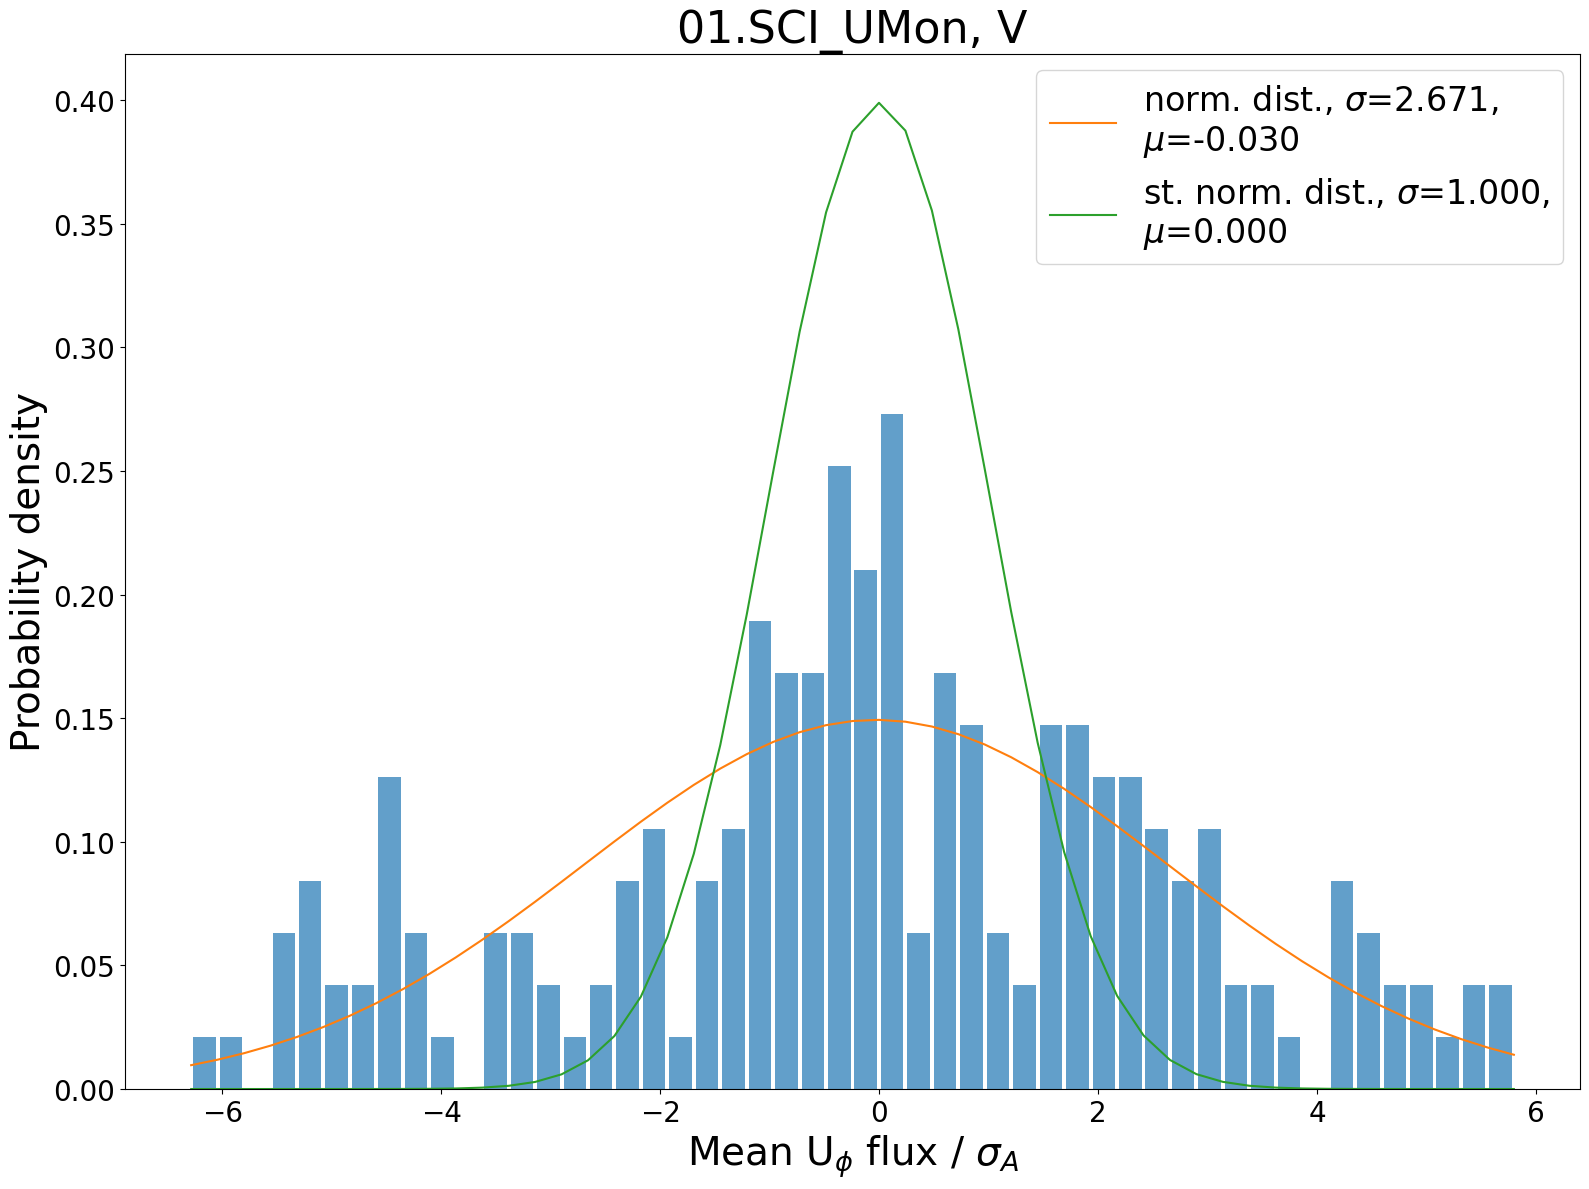

max u_phi 83.20856135754207
u_phi/q_phi for largest aperture -0.2091590148086035 , -/pi  -0.008980861448822094
q_phi/pi for largest aperture 0.0429379601784808


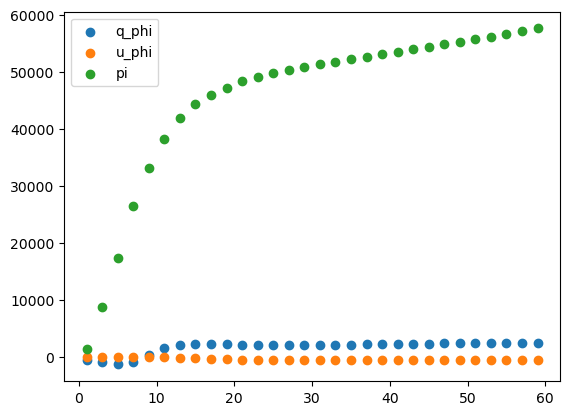

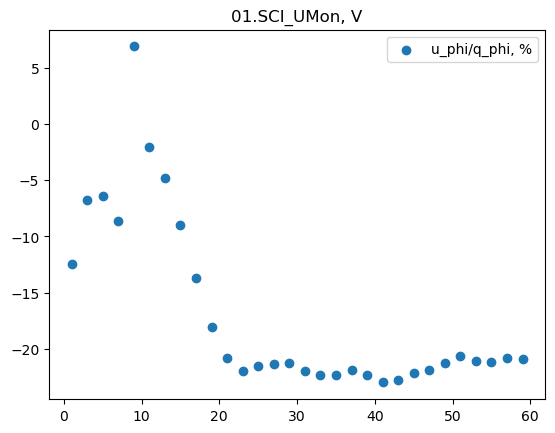

abs u_phi/q_phi for largest aperture 0.3311583873395243 , -/pi  0.18757839145613875
abs q_phi/pi for largest aperture 0.5664310451657734


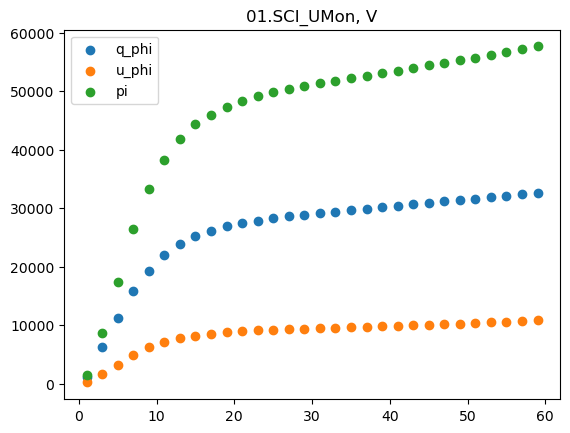

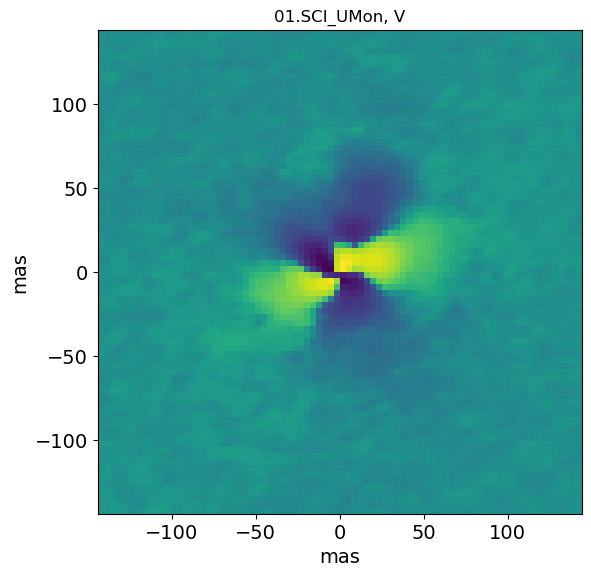

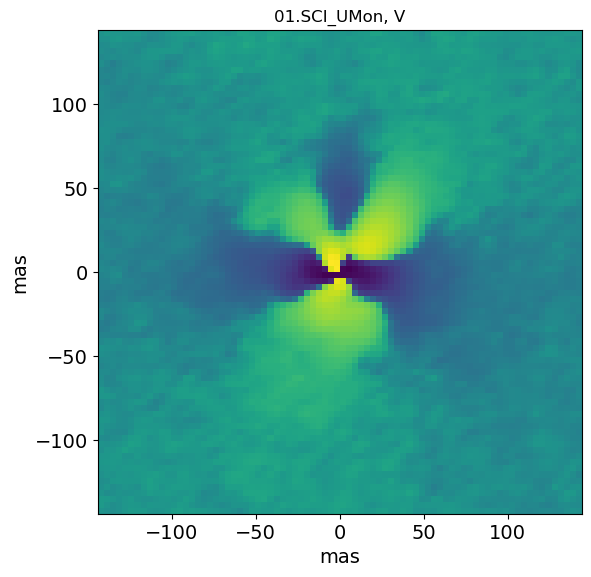

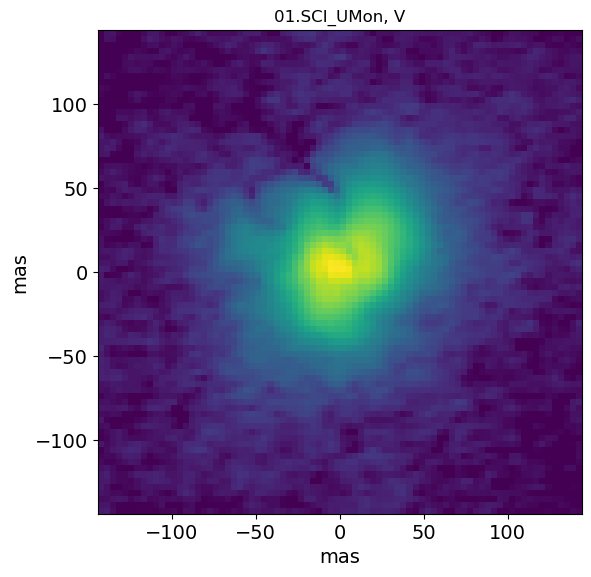

I


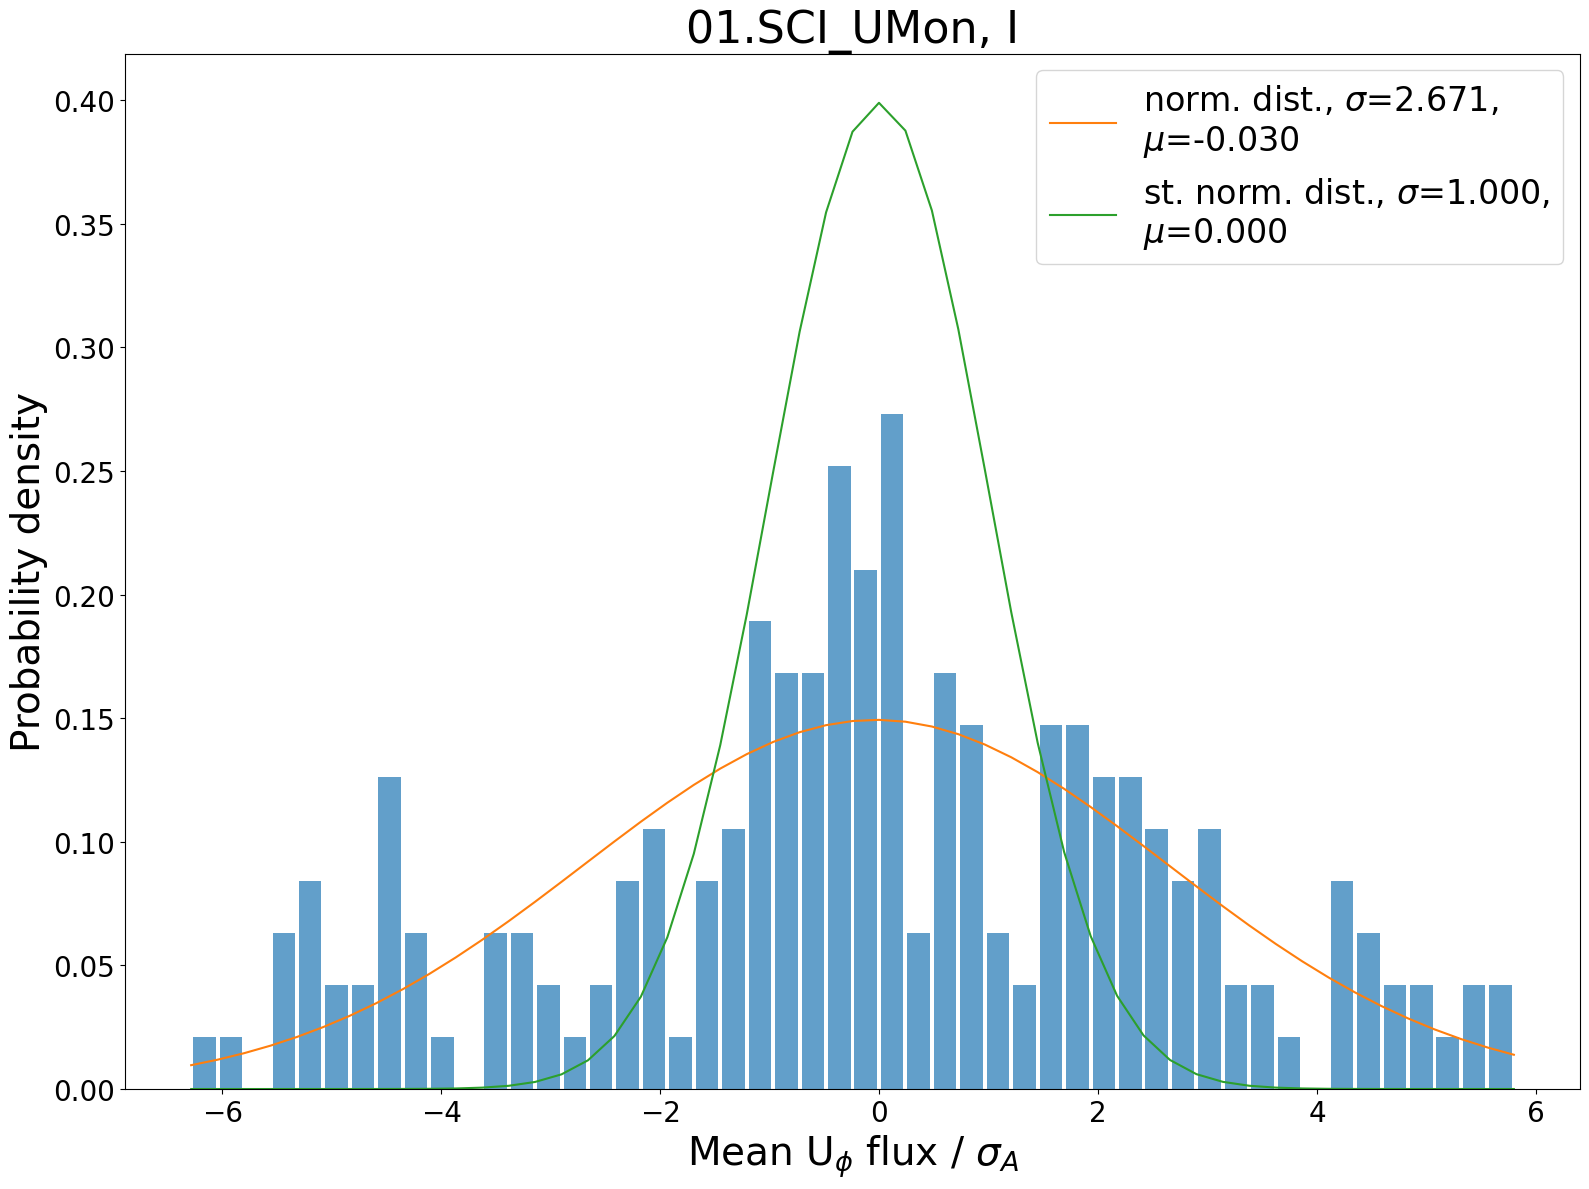

max u_phi 83.20856135754207
u_phi/q_phi for largest aperture -0.2091590148086035 , -/pi  -0.008980861448822094
q_phi/pi for largest aperture 0.0429379601784808


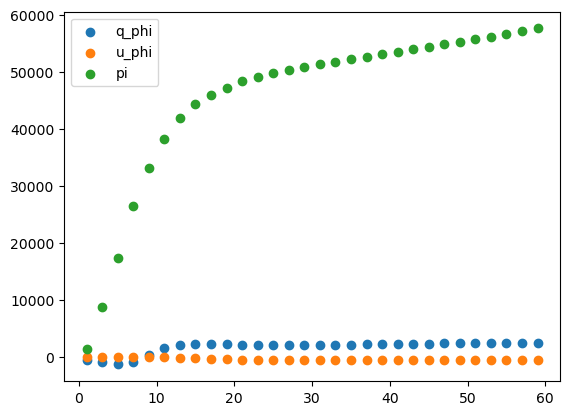

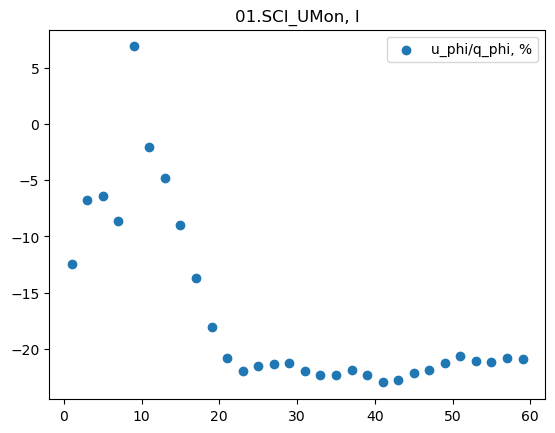

abs u_phi/q_phi for largest aperture 0.3311583873395243 , -/pi  0.18757839145613875
abs q_phi/pi for largest aperture 0.5664310451657734


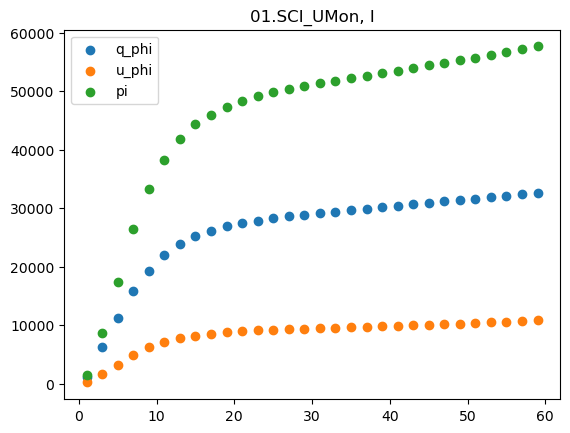

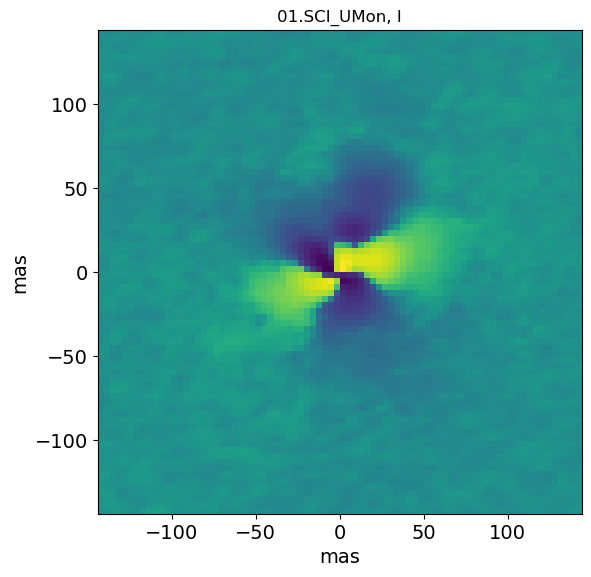

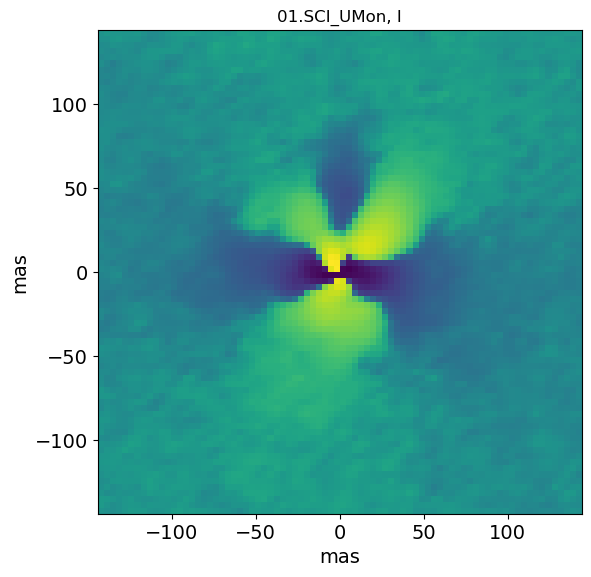

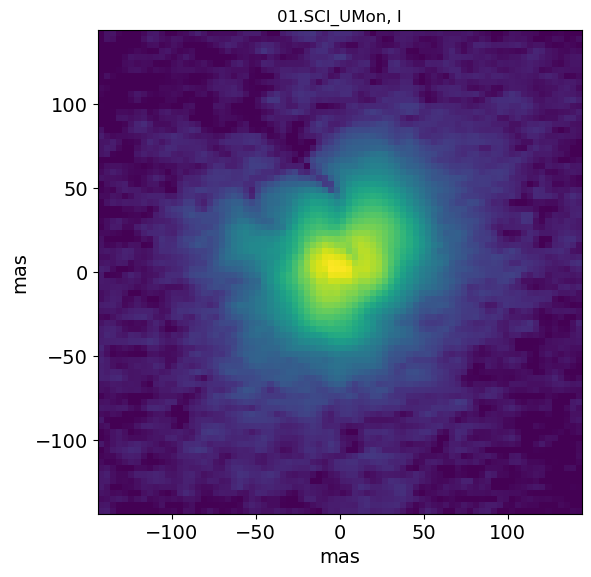

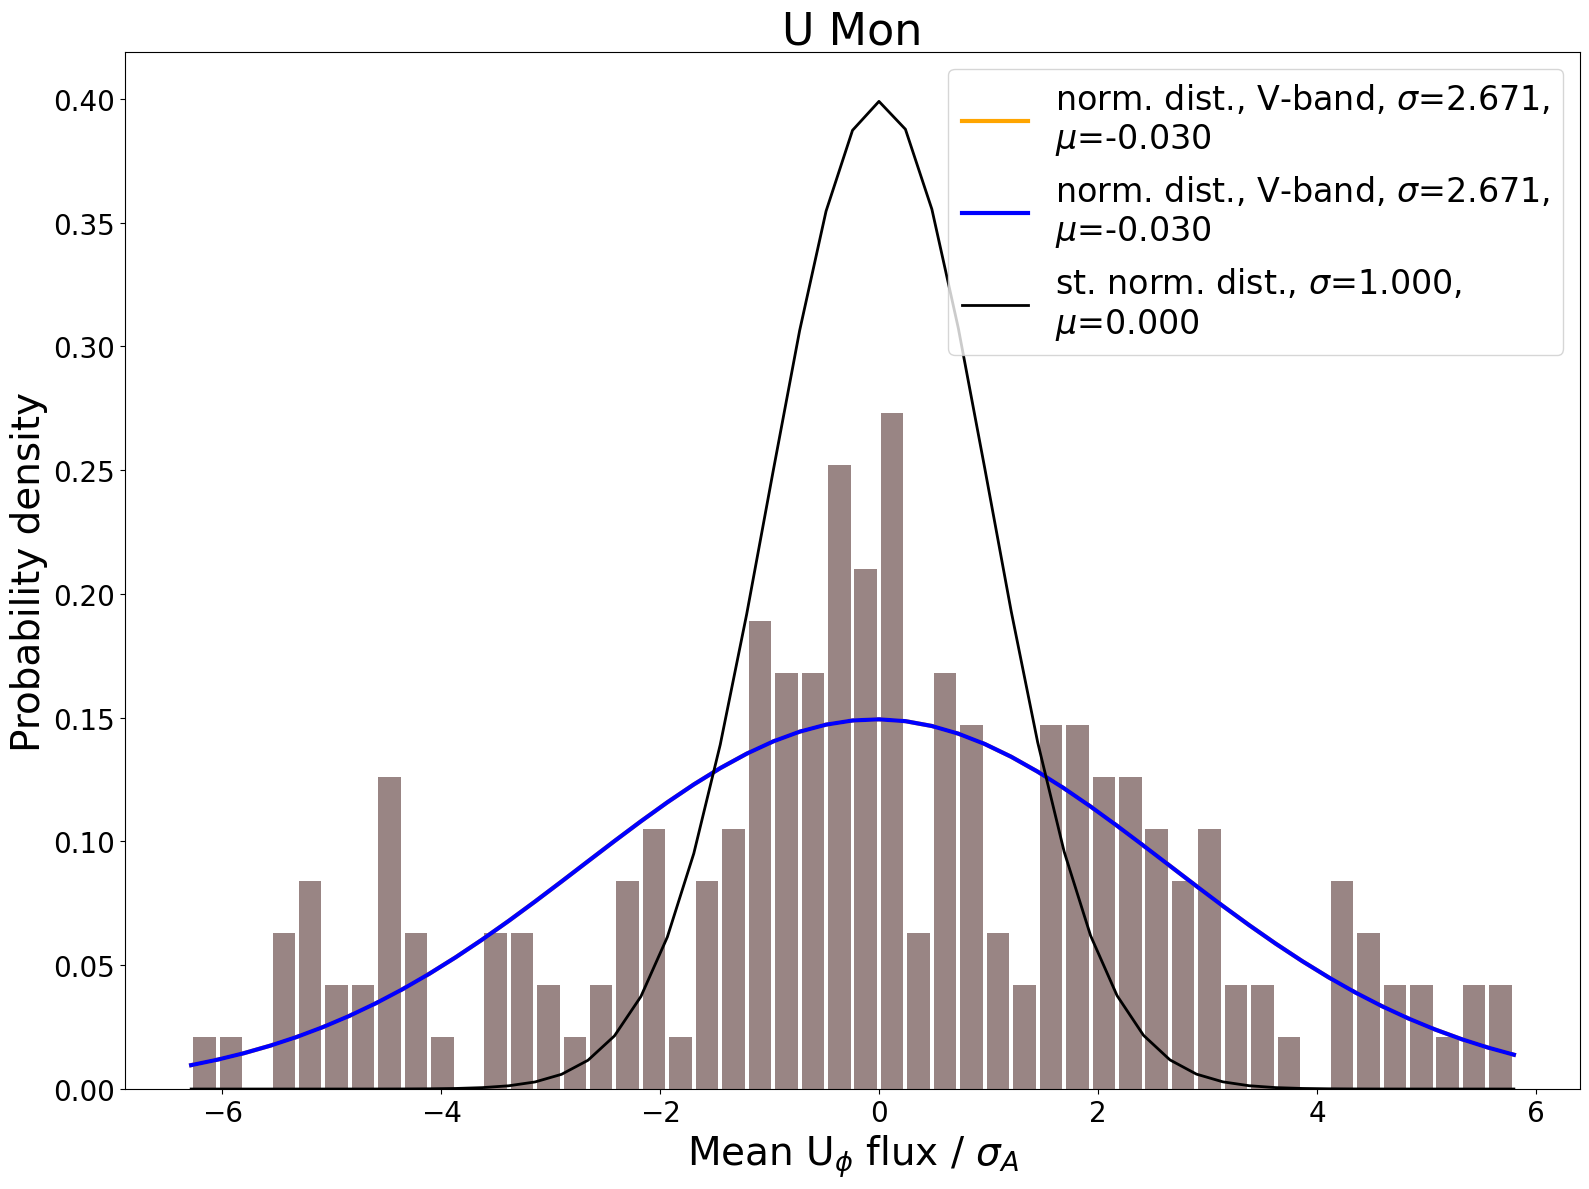

In [14]:
# ZIMPOL Data

for star in stars:

    figfolder='/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/'+star+'/Quality_indiv_cycles/'
    # createfolder(figfolder)
    print(star)

    for fittype in fittypes:

        print(band[int(fittype)-1])

        # go to directory containing the unres corr data (no psf)
        dirdat0='/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/'+star+'/Unres_corr/'
        files = os.listdir('/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/'+star+'/Unres_corr/')

        # for U_phi corrected
        ifile = 'uphi*.fits'
        for file in files:
            if fnmatch.fnmatch(file, ifile):
                hdul = fits.open(dirdat0 + file)
                u_phi_nondec = hdul['Primary'].data
                n=u_phi_nondec.shape[0]

        # for Q_phi corrected
        ifile = 'qphi*.fits'
        for file in files:
            if fnmatch.fnmatch(file, ifile):
                hdul = fits.open(dirdat0 + file)
                q_phi_nondec = hdul['Primary'].data

        # for PI corrected
        ifile = 'pi*.fits'
        for file in files:
            if fnmatch.fnmatch(file, ifile):
                hdul = fits.open(dirdat0 + file)
                pi_nondec = hdul['Primary'].data

        u_phi_an= u_phi_nondec*1.0

        # creating grid for the multiplying the image by the separation from star.
        xr = np.linspace(-n/2., n/2., num=n)
        yr = np.linspace(-n/2., n/2., num=n)
        Xr, Yr = np.meshgrid(xr, yr)
        R_an = np.sqrt(Xr**2 + Yr**2)

        # create histogram data
        hist_var_ar=[]
        hist_mean_ar=[]
        # loop over annulus range
        for hi_r in range (3,200,1):
            mask = (R_an < hi_r) & (R_an >=(hi_r-(math.sqrt(hi_r))))            # only considering this range
            image_u=u_phi_an[mask]                                              # mask everything else
            hist_variance=math.sqrt(np.var(image_u)/len(image_u))               # calculate the variance sqrt(var/n)
            hist_image_mean=np.mean(image_u)                                    # calculate mean
            hist_var_ar.append(hist_variance)
            hist_mean_ar.append(hist_image_mean)

        mean_over_var=np.array(hist_mean_ar)/np.array(hist_var_ar)              # ratio of mean over variance (~S/N)
        if fittype=='1':
            mean_over_var_V=mean_over_var
        if fittype=='2':
            mean_over_var_I=mean_over_var

        n_bins = 50
        fig, axs = plt.subplots(1, 1, tight_layout=True,figsize=(16,12))
        somth1, bins,somth2 = plt.hist(mean_over_var, bins=n_bins, density=True, alpha=0.7, rwidth=0.85)
        #print(somth1, bins,somth2)
        mu, sigma = scipy.stats.norm.fit(mean_over_var)

        best_fit_line = scipy.stats.norm.pdf(bins, mu, sigma)
        plt.plot(bins, best_fit_line, label="\n".join(wrap('norm. dist., $\sigma$=%.3f, $\mu$=%.3f'%(sigma,mu),40)))
        mu, sigma =(0,1)
        best_fit_line = scipy.stats.norm.pdf(bins, mu, sigma)
        plt.plot(bins, best_fit_line, label="\n".join(wrap('st. norm. dist., $\sigma$=%.3f, $\mu$=%.3f'%(sigma,mu), 40)))
        plt.title(star+', '+band[int(fittype)-1], fontsize=32)
        plt.xlabel(r'Mean U$_\phi$ flux / $\sigma_A$', fontsize=28)
        plt.ylabel('Probability density', fontsize=28)
        axs.xaxis.set_tick_params(labelsize=20)
        axs.yaxis.set_tick_params(labelsize=20)
        plt.legend(fontsize=24, loc='upper right')
        plt.savefig(figfolder+ star +'_'+band[int(fittype)-1]+ "hist.jpeg")
        plt.show()
        plt.close()

        # initialise
        q_phi_sum=[]
        u_phi_sum=[]
        pi_sum=[]

        for i_r in range(1,60,2):
            q_phi_sum.append(np.sum(q_phi_nondec[R_an<=i_r]))           # sum q_phi over inner ring
            u_phi_sum.append(np.sum(u_phi_nondec[R_an<=i_r]))           # sum u_phi over inner ring
            pi_sum.append(np.sum(pi_nondec[R_an<=i_r]))                 # sum  PI over inner ring

        q_phi_sum=np.array(q_phi_sum)
        u_phi_sum=np.array(u_phi_sum)
        pi_sum=np.array(pi_sum)
        print('max u_phi', np.max(u_phi_sum))
        print('u_phi/q_phi for largest aperture', u_phi_sum[-1]/q_phi_sum[-1], ', -/pi ', u_phi_sum[-1]/pi_sum[-1])
        print('q_phi/pi for largest aperture', q_phi_sum[-1]/pi_sum[-1])

        i_r_ar=range(1,60,2)
        plt.scatter(i_r_ar, q_phi_sum, label='q_phi')
        plt.scatter(i_r_ar, u_phi_sum, label='u_phi')
        plt.scatter(i_r_ar, pi_sum, label='pi')
        #plt.yscale('log')
        plt.legend()
        plt.show()
        plt.close()

        plt.scatter(i_r_ar, u_phi_sum/q_phi_sum*100, label='u_phi/q_phi, %')
        #plt.ylim(-10,10)
        plt.legend()
        plt.title(star+', '+band[int(fittype)-1])
        plt.show()
        plt.close()

        # now for absolute values for magnitude of polarisation
        q_phi_sum=[]
        u_phi_sum=[]
        pi_sum=[]

        for i_r in range(1,60,2):
            q_phi_sum.append(np.sum(abs(q_phi_nondec[R_an<=i_r])))
            u_phi_sum.append(np.sum(abs(u_phi_nondec[R_an<=i_r])))
            pi_sum.append(np.sum(abs(pi_nondec[R_an<=i_r])))

        q_phi_sum=np.array(q_phi_sum)
        u_phi_sum=np.array(u_phi_sum)
        pi_sum=np.array(pi_sum)

        print('abs u_phi/q_phi for largest aperture', u_phi_sum[-1]/q_phi_sum[-1], ', -/pi ', u_phi_sum[-1]/pi_sum[-1])
        print('abs q_phi/pi for largest aperture', q_phi_sum[-1]/pi_sum[-1])
        i_r_ar=range(1,60,2)
        plt.scatter(i_r_ar, q_phi_sum, label='q_phi')
        plt.scatter(i_r_ar, u_phi_sum, label='u_phi')
        plt.scatter(i_r_ar, pi_sum, label='pi')
        plt.title('abs')
        plt.legend()
        plt.title(star+', '+band[int(fittype)-1])
        plt.show()
        plt.close()

        # define radius to be plotted & limits
        d = (n-1) * ps / 2
        lim=40

        for image_a in [u_phi_nondec,q_phi_nondec,pi_nondec]:

            fig, ax = plt.subplots(figsize=(6, 6))
            image = np.arcsinh(image_a)
            max = np.max(image[int(n/2-lim/2):int(n/2+lim/2),int(n/2-lim/2):int(n/2+lim/2)])
            min=np.min(image[int(n/2-lim/2):int(n/2+lim/2),int(n/2-lim/2):int(n/2+lim/2)])
            ax.imshow(image, vmin=min, vmax=max, extent=(-d, d, d, -d))
            ax.set_xlim(-lim * ps, lim * ps)
            ax.set_ylim(-lim * ps, lim * ps)
            ax.set_xlabel('mas',fontsize=14)
            ax.set_ylabel('mas',fontsize=14)
            ax.tick_params(axis='both',labelsize=14)

            plt.title(star+', '+band[int(fittype)-1])
            plt.tight_layout()
            plt.show()
            plt.close()

    n_bins = 50
    fig, axs = plt.subplots(1, 1, tight_layout=True,figsize=(16,12))
    somth1_V, bins_V,somth2_V = plt.hist(mean_over_var_V, bins=n_bins, density=True, alpha=0.8, rwidth=0.85, color='gold')
    mu_V, sigma_V = scipy.stats.norm.fit(mean_over_var_V)
    best_fit_line_V = scipy.stats.norm.pdf(bins_V, mu_V, sigma_V)
    plt.plot(bins_V, best_fit_line_V, label="\n".join(wrap('norm. dist., V-band, $\sigma$=%.3f, $\mu$=%.3f'%(sigma_V,mu_V),40)), color='orange', linewidth=3)

    somth1_I, bins_I,somth2_I = plt.hist(mean_over_var_I, bins=n_bins, density=True, alpha=0.4, rwidth=0.85, color='blue')
    mu_I, sigma_I = scipy.stats.norm.fit(mean_over_var_I)
    best_fit_line_I = scipy.stats.norm.pdf(bins_I, mu_I, sigma_I)
    plt.plot(bins_I, best_fit_line_I, label="\n".join(wrap('norm. dist., V-band, $\sigma$=%.3f, $\mu$=%.3f'%(sigma_I,mu_I),40)), color='blue', linewidth=3)

    mu, sigma =(0,1)
    best_fit_line = scipy.stats.norm.pdf(bins, mu, sigma)
    plt.plot(bins, best_fit_line, label="\n".join(wrap('st. norm. dist., $\sigma$=%.3f, $\mu$=%.3f'%(sigma,mu), 40)), color='black', linewidth=2)

    plt.title(starnames[star], fontsize=32)
    plt.xlabel(r'Mean U$_\phi$ flux / $\sigma_A$', fontsize=28)
    plt.ylabel('Probability density', fontsize=28)
    axs.xaxis.set_tick_params(labelsize=20)
    axs.yaxis.set_tick_params(labelsize=20)
    plt.legend(fontsize=24, loc='upper right')
    plt.savefig(figfolder + star +'_both_bands_hist.jpeg')
    plt.show()
    plt.close()

In [15]:
band[1]

'I'

<>:70: SyntaxWarning: invalid escape sequence '\s'
<>:73: SyntaxWarning: invalid escape sequence '\s'
<>:170: SyntaxWarning: invalid escape sequence '\s'
<>:175: SyntaxWarning: invalid escape sequence '\s'
<>:179: SyntaxWarning: invalid escape sequence '\s'
<>:70: SyntaxWarning: invalid escape sequence '\s'
<>:73: SyntaxWarning: invalid escape sequence '\s'
<>:170: SyntaxWarning: invalid escape sequence '\s'
<>:175: SyntaxWarning: invalid escape sequence '\s'
<>:179: SyntaxWarning: invalid escape sequence '\s'
/var/folders/xc/tr18j41x0lgdjpw201cfd6w00000gp/T/ipykernel_75076/3884726762.py:70: SyntaxWarning: invalid escape sequence '\s'
  plt.plot(bins, best_fit_line, label="\n".join(wrap('norm. dist., $\sigma$=%.3f, $\mu$=%.3f'%(sigma,mu),40)))
/var/folders/xc/tr18j41x0lgdjpw201cfd6w00000gp/T/ipykernel_75076/3884726762.py:73: SyntaxWarning: invalid escape sequence '\s'
  plt.plot(bins, best_fit_line, label="\n".join(wrap('st. norm. dist., $\sigma$=%.3f, $\mu$=%.3f'%(sigma,mu), 40)))
/va

01.SCI_UMon


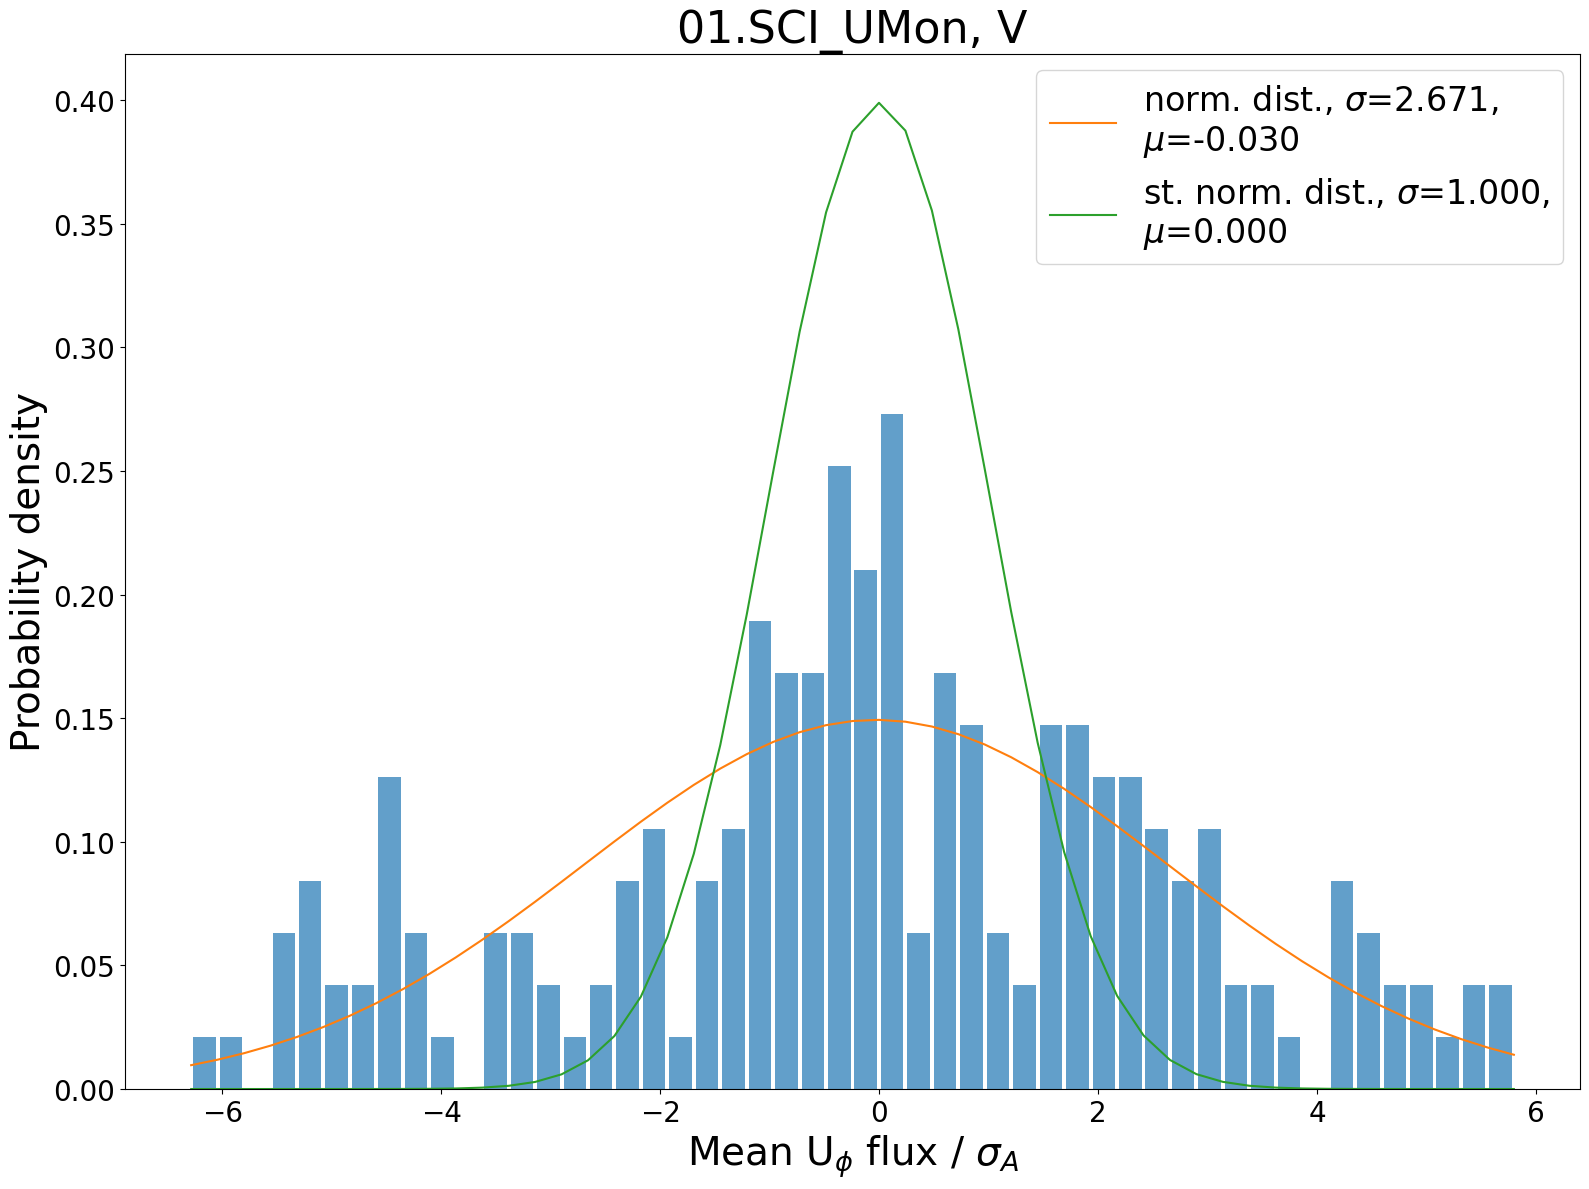

max u_phi 83.20856135754207
u_phi/q_phi for largest aperture -0.2091590148086035 , -/pi  -0.008980861448822094
q_phi/pi for largest aperture 0.0429379601784808


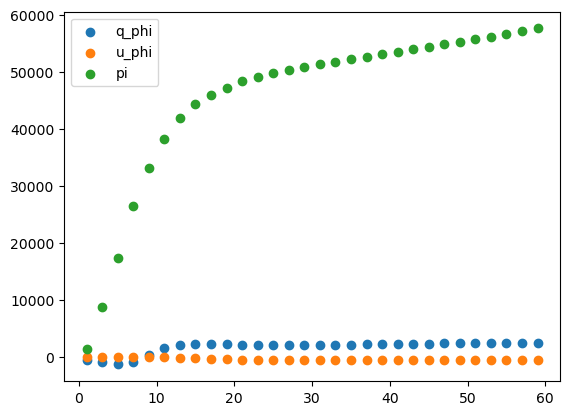

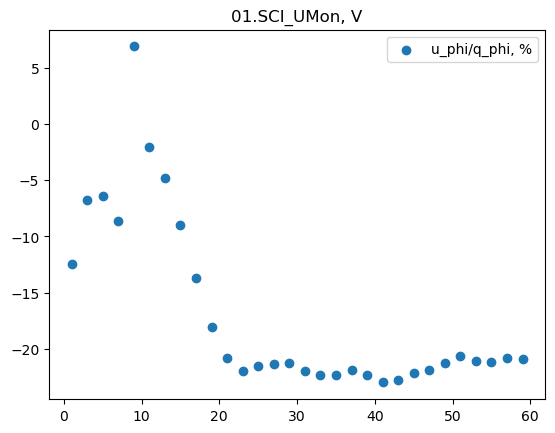

abs u_phi/q_phi for largest aperture 0.3311583873395243 , -/pi  0.18757839145613875
abs q_phi/pi for largest aperture 0.5664310451657734


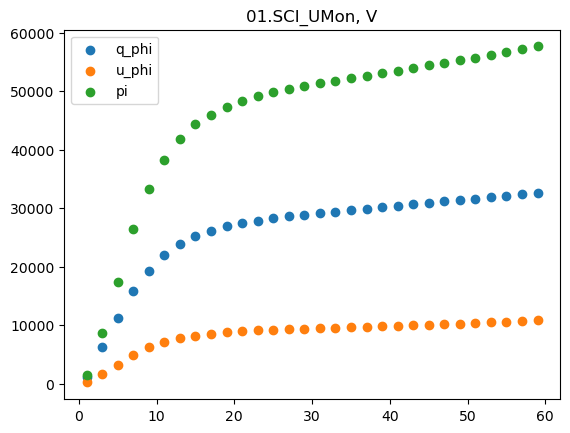

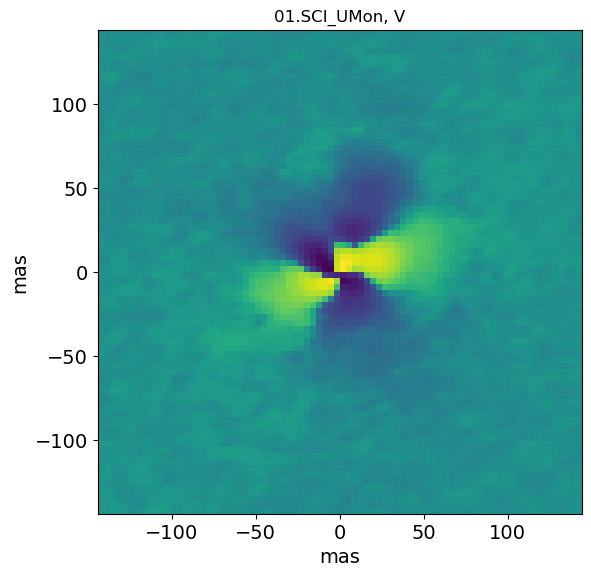

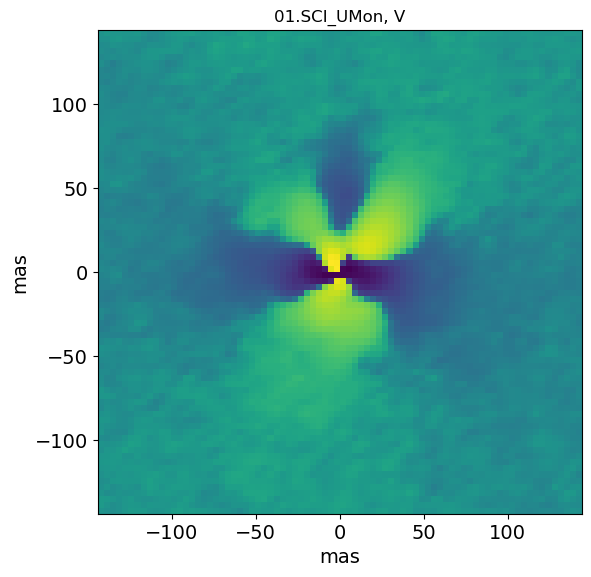

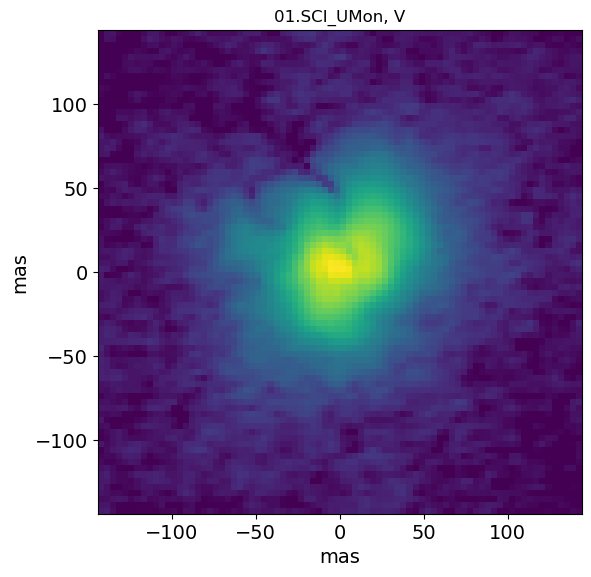

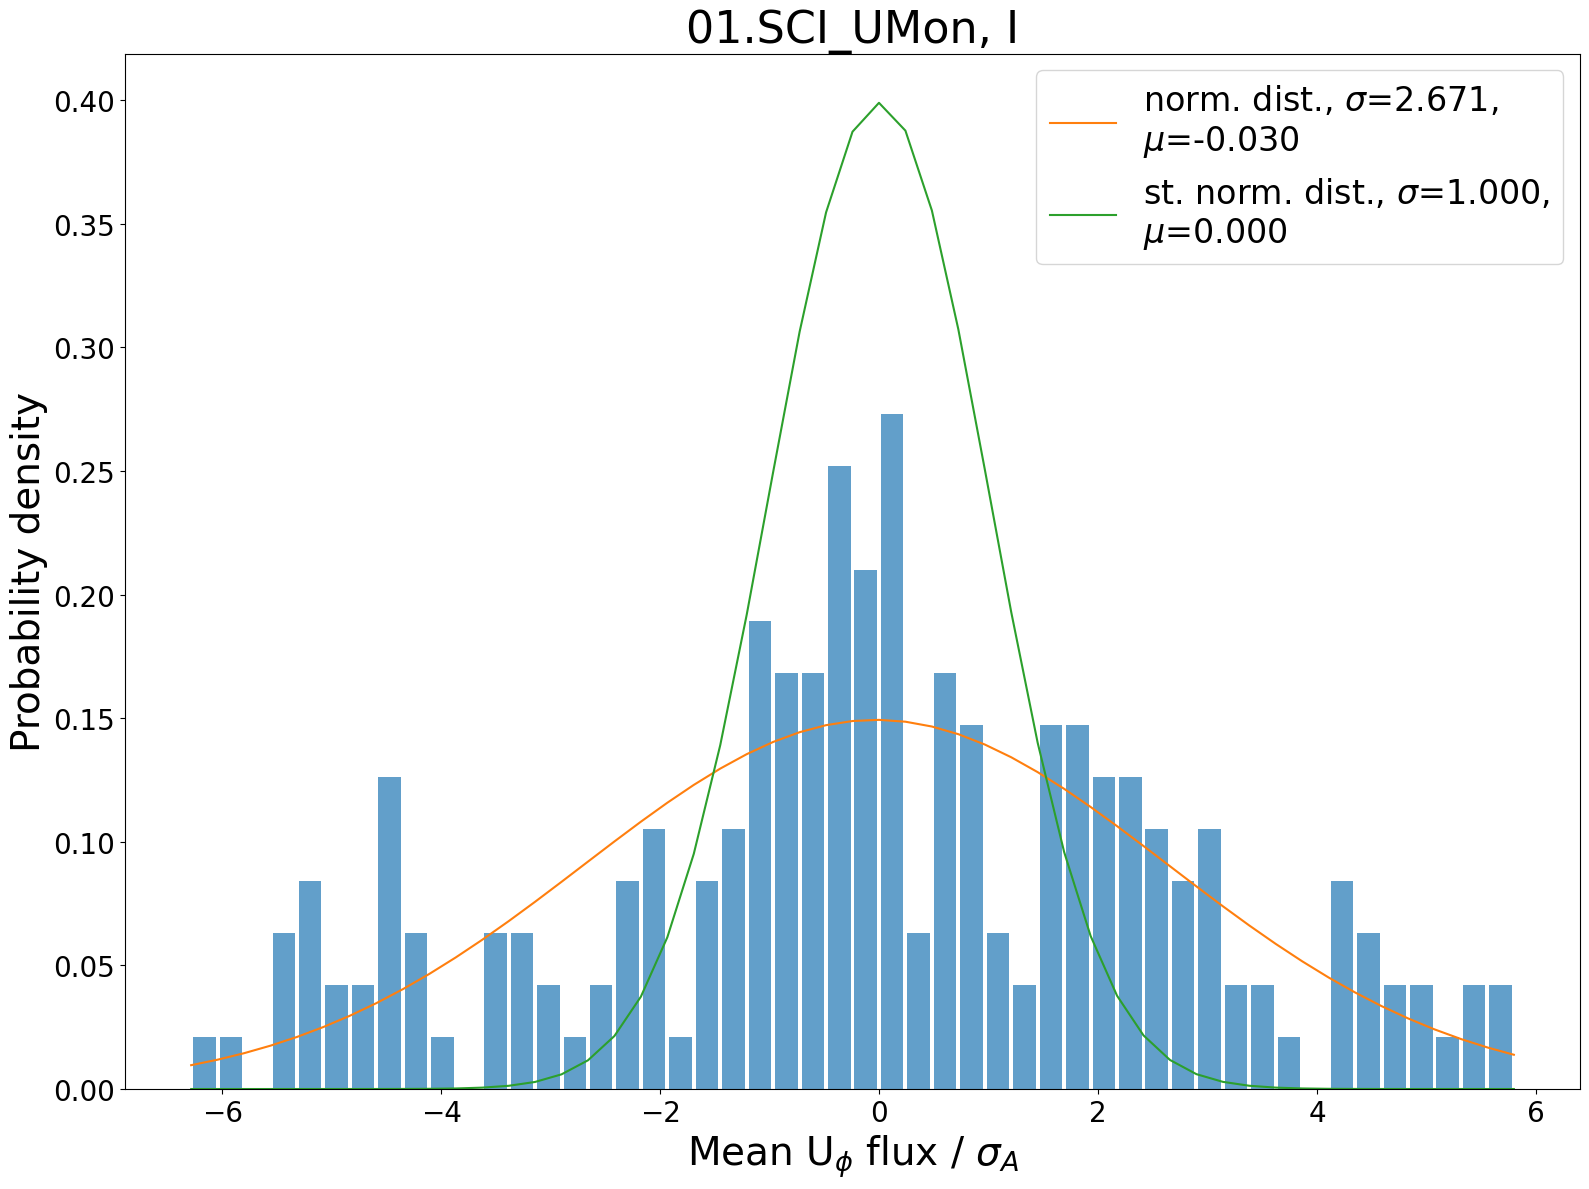

max u_phi 83.20856135754207
u_phi/q_phi for largest aperture -0.2091590148086035 , -/pi  -0.008980861448822094
q_phi/pi for largest aperture 0.0429379601784808


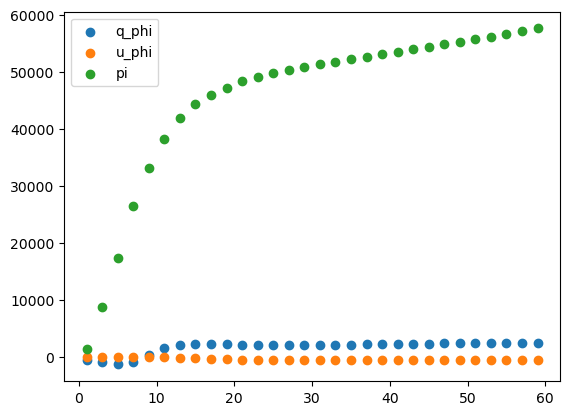

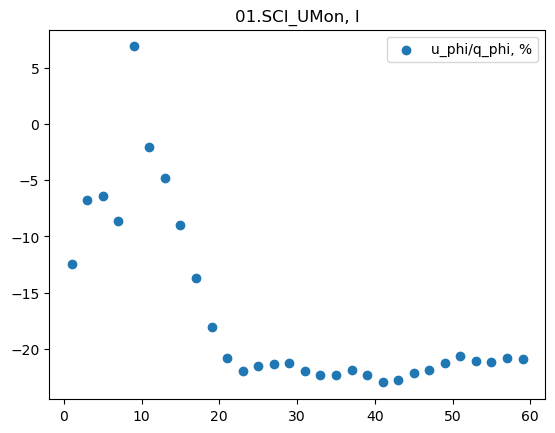

abs u_phi/q_phi for largest aperture 0.3311583873395243 , -/pi  0.18757839145613875
abs q_phi/pi for largest aperture 0.5664310451657734


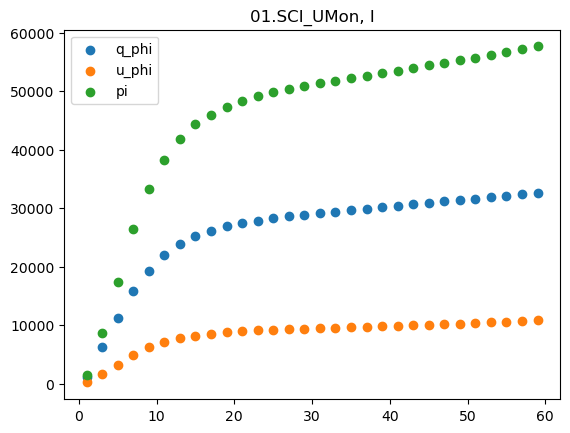

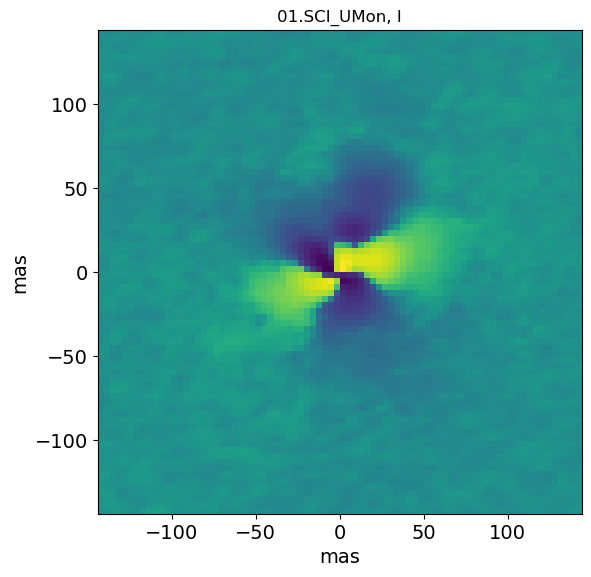

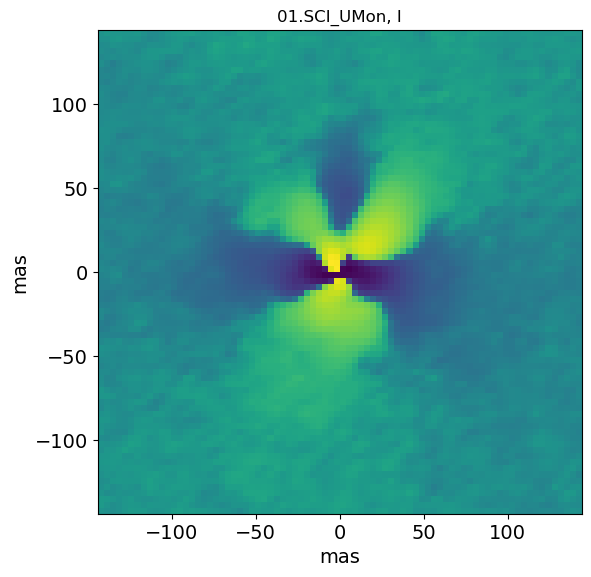

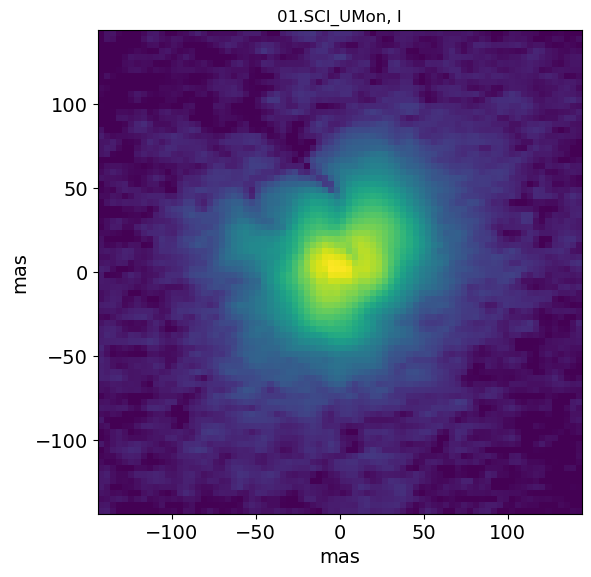

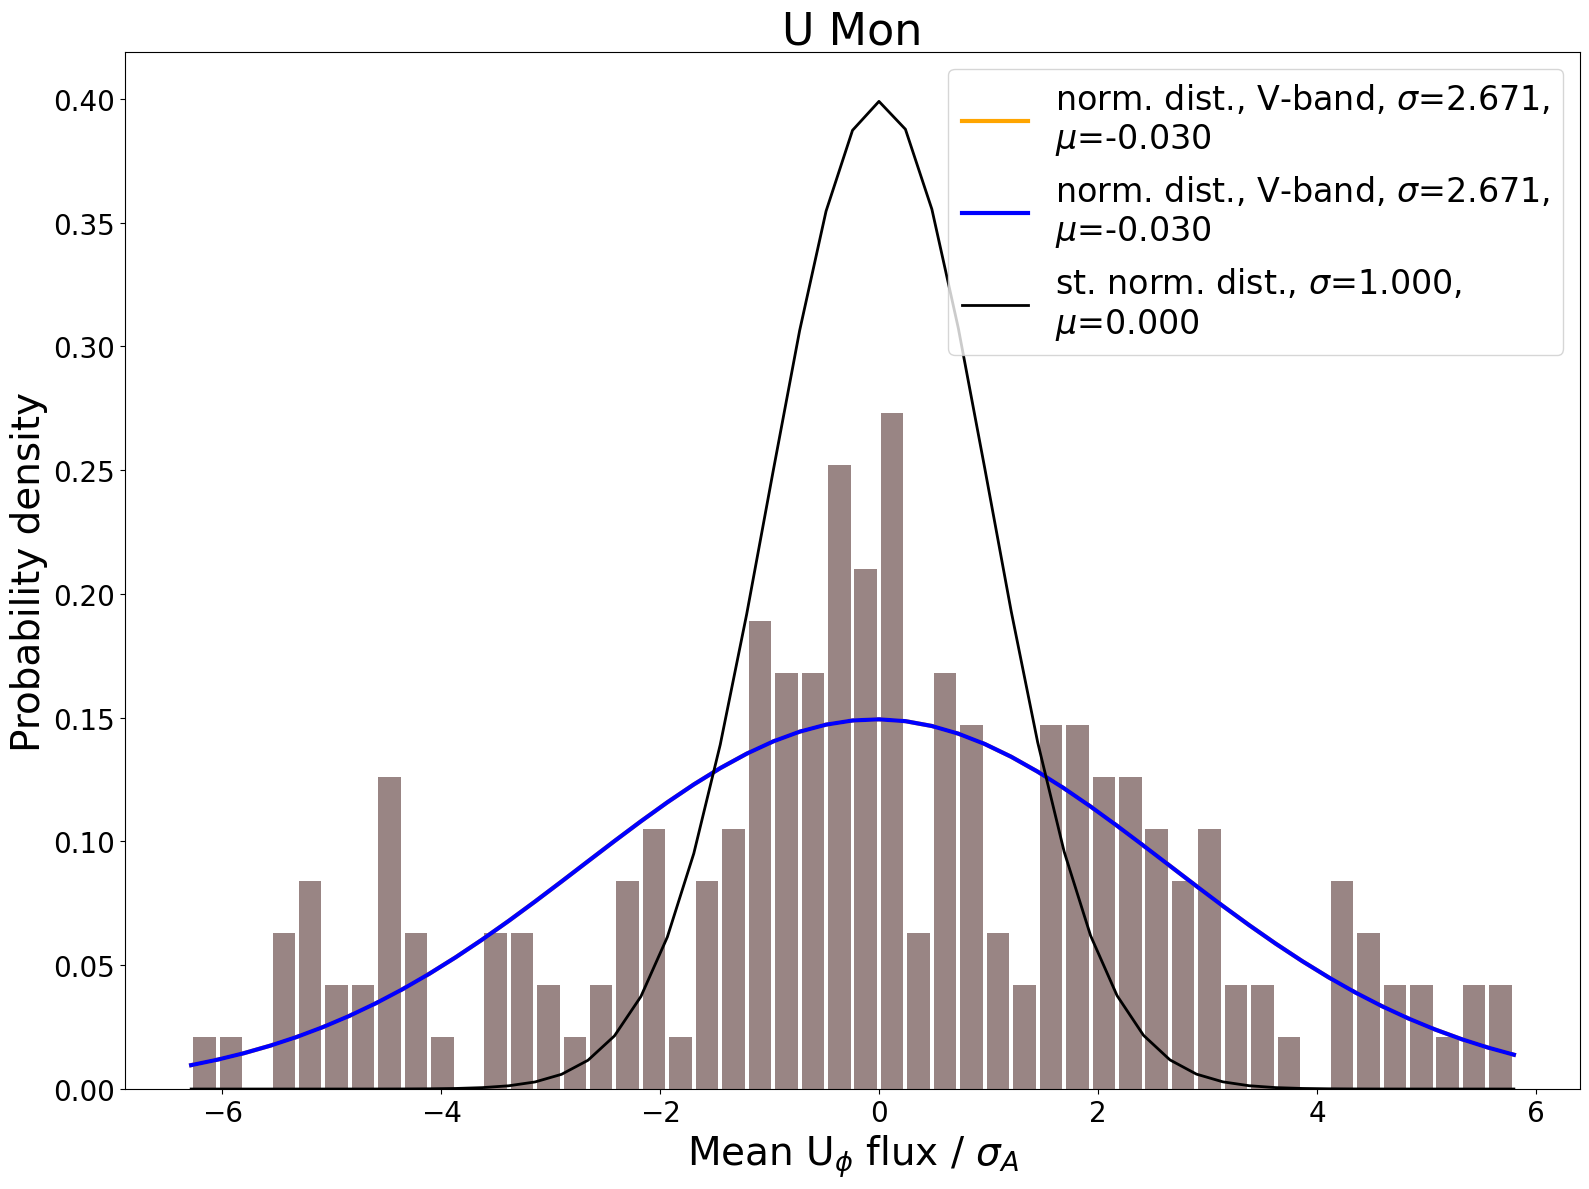

In [16]:
# ZIMPOL Data

for star in stars:

    figfolder='/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/'+star+'/Quality_indiv_cycles/'+'ZIMPOL/'
    createfolder(figfolder)
    print(star)

    for fittype in fittypes:

        # go to directory containing the unres corr data (no psf)
        dirdat0='/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/'+star+'/Unres_corr/'
        files = os.listdir('/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/'+star+'/Unres_corr/')

        # for U_phi corrected
        ifile = 'uphi_UMon*.fits'
        for file in files:
            if fnmatch.fnmatch(file, ifile):
                hdul = fits.open(dirdat0 + file)
                u_phi_nondec = hdul['Primary'].data
                n=u_phi_nondec.shape[0]

        # for Q_phi corrected
        ifile = 'qphi_UMon*.fits'
        for file in files:
            if fnmatch.fnmatch(file, ifile):
                hdul = fits.open(dirdat0 + file)
                q_phi_nondec = hdul['Primary'].data

        # for PI corrected
        ifile = 'pi*.fits'
        for file in files:
            if fnmatch.fnmatch(file, ifile):
                hdul = fits.open(dirdat0 + file)
                pi_nondec = hdul['Primary'].data

        u_phi_an= u_phi_nondec*1.0

        # creating grid for the multiplying the image by the separation from star.
        xr = np.linspace(-n/2., n/2., num=n)
        yr = np.linspace(-n/2., n/2., num=n)
        Xr, Yr = np.meshgrid(xr, yr)
        R_an = np.sqrt(Xr**2 + Yr**2)

        # create histogram data
        hist_var_ar=[]
        hist_mean_ar=[]
        # loop over annulus range
        for hi_r in range (3,200,1):
            mask = (R_an < hi_r) & (R_an >=(hi_r-(math.sqrt(hi_r))))            # only considering this range
            image_u=u_phi_an[mask]                                              # mask everything else
            hist_variance=math.sqrt(np.var(image_u)/len(image_u))               # calculate the variance sqrt(var/n)
            hist_image_mean=np.mean(image_u)                                    # calculate mean
            hist_var_ar.append(hist_variance)
            hist_mean_ar.append(hist_image_mean)

        mean_over_var=np.array(hist_mean_ar)/np.array(hist_var_ar)              # ratio of mean over variance (~S/N)
        if fittype=='1':
            mean_over_var_V=mean_over_var
        if fittype=='2':
            mean_over_var_I=mean_over_var

        n_bins = 50
        fig, axs = plt.subplots(1, 1, tight_layout=True,figsize=(16,12))
        somth1, bins,somth2 = plt.hist(mean_over_var, bins=n_bins, density=True, alpha=0.7, rwidth=0.85)
        # print(somth1, bins,somth2)
        mu, sigma = scipy.stats.norm.fit(mean_over_var)

        best_fit_line = scipy.stats.norm.pdf(bins, mu, sigma)
        plt.plot(bins, best_fit_line, label="\n".join(wrap('norm. dist., $\sigma$=%.3f, $\mu$=%.3f'%(sigma,mu),40)))
        mu, sigma =(0,1)
        best_fit_line = scipy.stats.norm.pdf(bins, mu, sigma)
        plt.plot(bins, best_fit_line, label="\n".join(wrap('st. norm. dist., $\sigma$=%.3f, $\mu$=%.3f'%(sigma,mu), 40)))
        plt.title(star+', '+band[int(fittype)-1], fontsize=32)
        plt.xlabel(r'Mean U$_\phi$ flux / $\sigma_A$', fontsize=28)
        plt.ylabel('Probability density', fontsize=28)
        axs.xaxis.set_tick_params(labelsize=20)
        axs.yaxis.set_tick_params(labelsize=20)
        plt.legend(fontsize=24, loc='upper right')
        plt.savefig(figfolder+ star +'_'+band[int(fittype)-1]+ "hist.jpeg")
        plt.show()
        plt.close()

        # initialise
        q_phi_sum=[]
        u_phi_sum=[]
        pi_sum=[]

        for i_r in range(1,60,2):
            q_phi_sum.append(np.sum(q_phi_nondec[R_an<=i_r]))           # sum q_phi over inner ring
            u_phi_sum.append(np.sum(u_phi_nondec[R_an<=i_r]))           # sum u_phi over inner ring
            pi_sum.append(np.sum(pi_nondec[R_an<=i_r]))                 # sum  PI over inner ring

        q_phi_sum=np.array(q_phi_sum)
        u_phi_sum=np.array(u_phi_sum)
        pi_sum=np.array(pi_sum)
        print('max u_phi', np.max(u_phi_sum))
        print('u_phi/q_phi for largest aperture', u_phi_sum[-1]/q_phi_sum[-1], ', -/pi ', u_phi_sum[-1]/pi_sum[-1])
        print('q_phi/pi for largest aperture', q_phi_sum[-1]/pi_sum[-1])

        i_r_ar=range(1,60,2)
        plt.scatter(i_r_ar, q_phi_sum, label='q_phi')
        plt.scatter(i_r_ar, u_phi_sum, label='u_phi')
        plt.scatter(i_r_ar, pi_sum, label='pi')
        #plt.yscale('log')
        plt.legend()
        plt.show()
        plt.close()

        plt.scatter(i_r_ar, u_phi_sum/q_phi_sum*100, label='u_phi/q_phi, %')
        #plt.ylim(-10,10)
        plt.legend()
        plt.title(star+', '+band[int(fittype)-1])
        plt.show()
        plt.close()

        # now for absolute values for magnitude of polarisation
        q_phi_sum=[]
        u_phi_sum=[]
        pi_sum=[]

        for i_r in range(1,60,2):
            q_phi_sum.append(np.sum(abs(q_phi_nondec[R_an<=i_r])))
            u_phi_sum.append(np.sum(abs(u_phi_nondec[R_an<=i_r])))
            pi_sum.append(np.sum(abs(pi_nondec[R_an<=i_r])))

        q_phi_sum=np.array(q_phi_sum)
        u_phi_sum=np.array(u_phi_sum)
        pi_sum=np.array(pi_sum)

        print('abs u_phi/q_phi for largest aperture', u_phi_sum[-1]/q_phi_sum[-1], ', -/pi ', u_phi_sum[-1]/pi_sum[-1])
        print('abs q_phi/pi for largest aperture', q_phi_sum[-1]/pi_sum[-1])
        i_r_ar=range(1,60,2)
        plt.scatter(i_r_ar, q_phi_sum, label='q_phi')
        plt.scatter(i_r_ar, u_phi_sum, label='u_phi')
        plt.scatter(i_r_ar, pi_sum, label='pi')
        plt.title('abs')
        plt.legend()
        plt.title(star+', '+band[int(fittype)-1])
        plt.show()
        plt.close()

        # define radius to be plotted & limits
        d = (n-1) * ps / 2
        lim=40

        for image_a in [u_phi_nondec,q_phi_nondec,pi_nondec]:

            fig, ax = plt.subplots(figsize=(6, 6))
            image = np.arcsinh(image_a)
            max = np.max(image[int(n/2-lim/2):int(n/2+lim/2),int(n/2-lim/2):int(n/2+lim/2)])
            min=np.min(image[int(n/2-lim/2):int(n/2+lim/2),int(n/2-lim/2):int(n/2+lim/2)])
            ax.imshow(image, vmin=min, vmax=max, extent=(-d, d, d, -d))
            ax.set_xlim(-lim * ps, lim * ps)
            ax.set_ylim(-lim * ps, lim * ps)
            ax.set_xlabel('mas',fontsize=14)
            ax.set_ylabel('mas',fontsize=14)
            ax.tick_params(axis='both',labelsize=14)

            plt.title(star+', '+band[int(fittype)-1])
            plt.tight_layout()
            plt.show()
            plt.close()

    n_bins = 50
    fig, axs = plt.subplots(1, 1, tight_layout=True,figsize=(16,12))
    somth1_V, bins_V,somth2_V = plt.hist(mean_over_var_V, bins=n_bins, density=True, alpha=0.8, rwidth=0.85, color='gold')
    mu_V, sigma_V = scipy.stats.norm.fit(mean_over_var_V)
    best_fit_line_V = scipy.stats.norm.pdf(bins_V, mu_V, sigma_V)
    plt.plot(bins_V, best_fit_line_V, label="\n".join(wrap('norm. dist., V-band, $\sigma$=%.3f, $\mu$=%.3f'%(sigma_V,mu_V),40)), color='orange', linewidth=3)

    somth1_I, bins_I,somth2_I = plt.hist(mean_over_var_I, bins=n_bins, density=True, alpha=0.4, rwidth=0.85, color='blue')
    mu_I, sigma_I = scipy.stats.norm.fit(mean_over_var_I)
    best_fit_line_I = scipy.stats.norm.pdf(bins_I, mu_I, sigma_I)
    plt.plot(bins_I, best_fit_line_I, label="\n".join(wrap('norm. dist., V-band, $\sigma$=%.3f, $\mu$=%.3f'%(sigma_I,mu_I),40)), color='blue', linewidth=3)

    mu, sigma =(0,1)
    best_fit_line = scipy.stats.norm.pdf(bins, mu, sigma)
    plt.plot(bins, best_fit_line, label="\n".join(wrap('st. norm. dist., $\sigma$=%.3f, $\mu$=%.3f'%(sigma,mu), 40)), color='black', linewidth=2)

    plt.title(starnames[star], fontsize=32)
    plt.xlabel(r'Mean U$_\phi$ flux / $\sigma_A$', fontsize=28)
    plt.ylabel('Probability density', fontsize=28)
    axs.xaxis.set_tick_params(labelsize=20)
    axs.yaxis.set_tick_params(labelsize=20)
    plt.legend(fontsize=24, loc='upper right')
    plt.savefig(figfolder + star +'_both_bands_hist.jpeg')
    plt.show()
    plt.close()

#### IRDIS

In [17]:
def create_dir(dirname):
    if not os.path.isdir(dirname):
        os.makedirs(dirname, exist_ok=True)

In [18]:
fittypes = ['1']

In [24]:
band = ['H','H']

<>:61: SyntaxWarning: invalid escape sequence '\s'
<>:64: SyntaxWarning: invalid escape sequence '\s'
<>:61: SyntaxWarning: invalid escape sequence '\s'
<>:64: SyntaxWarning: invalid escape sequence '\s'
/var/folders/xc/tr18j41x0lgdjpw201cfd6w00000gp/T/ipykernel_75076/4122798826.py:61: SyntaxWarning: invalid escape sequence '\s'
  plt.plot(bins, best_fit_line, label="\n".join(wrap('norm. dist., $\sigma$=%.3f, $\mu$=%.3f'%(sigma,mu),40)))
/var/folders/xc/tr18j41x0lgdjpw201cfd6w00000gp/T/ipykernel_75076/4122798826.py:64: SyntaxWarning: invalid escape sequence '\s'
  plt.plot(bins, best_fit_line, label="\n".join(wrap('st. norm. dist., $\sigma$=%.3f, $\mu$=%.3f'%(sigma,mu), 40)))


01.SCI_UMon


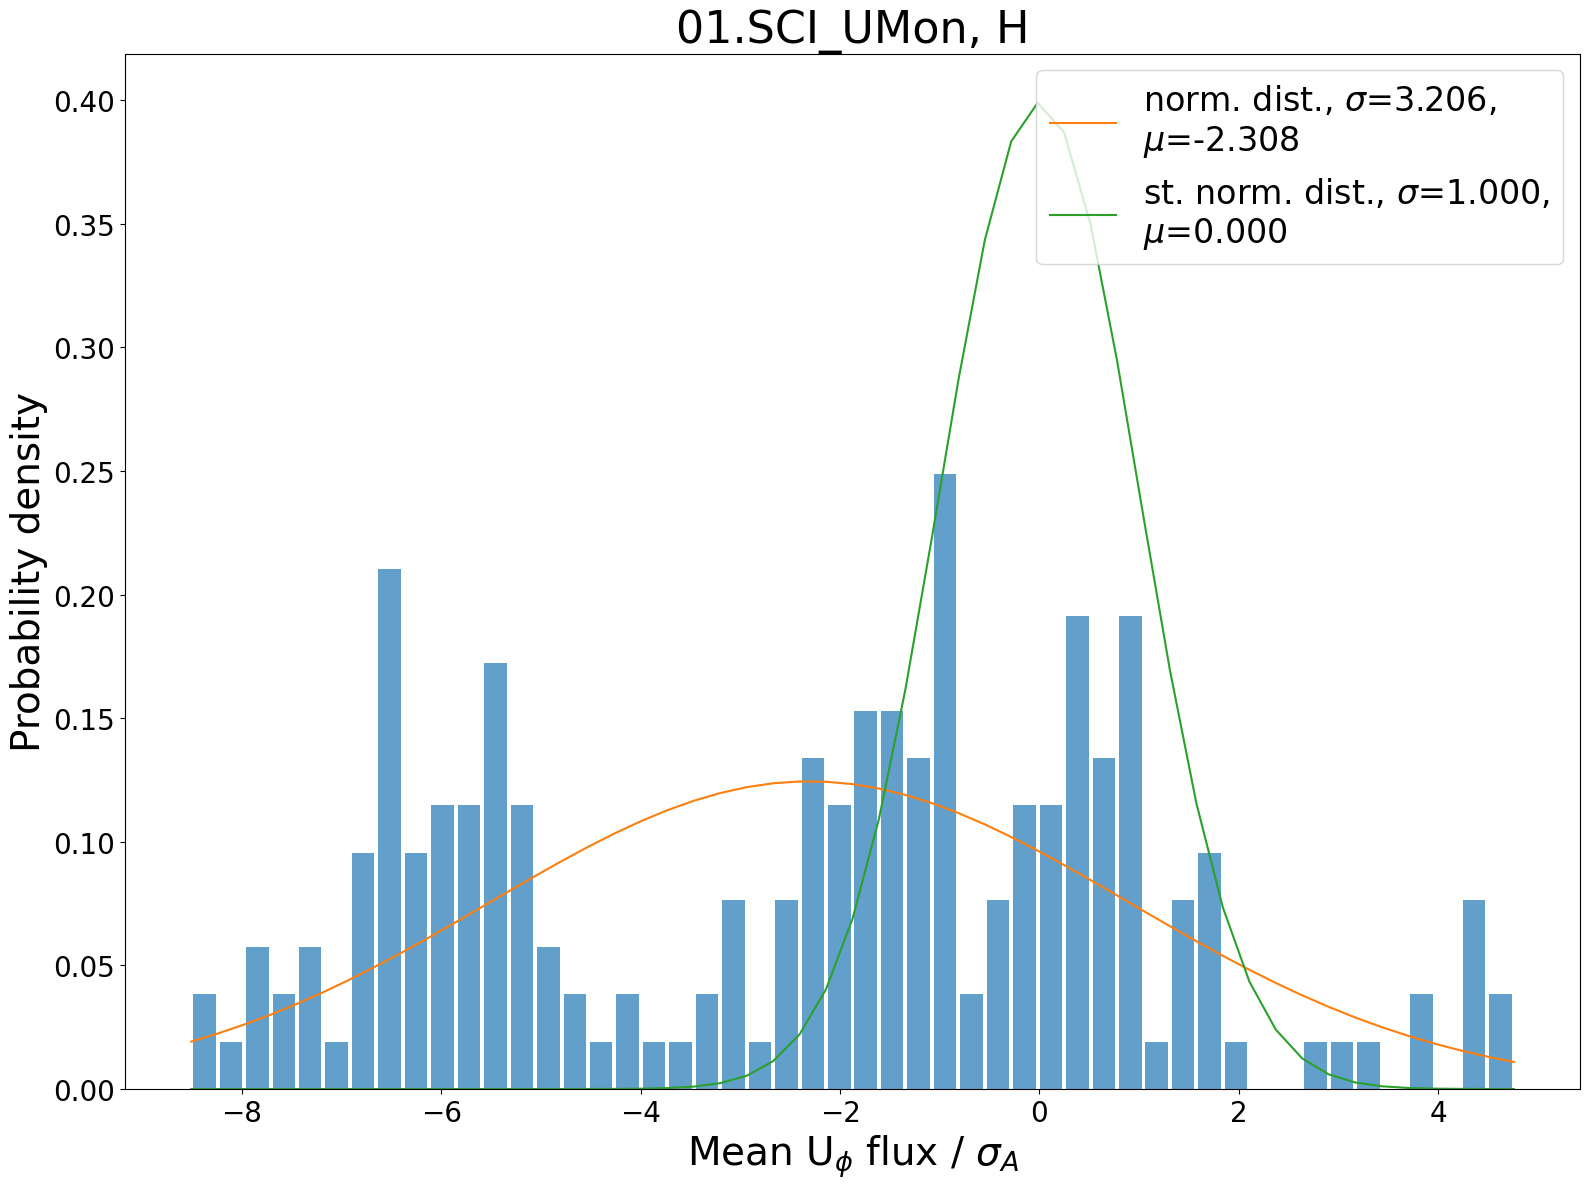

max u_phi 67.07564
u_phi/q_phi for largest apperture -0.25727656 , -/pi  -0.023862733
q_phi/pi for largest apperture 0.09275129


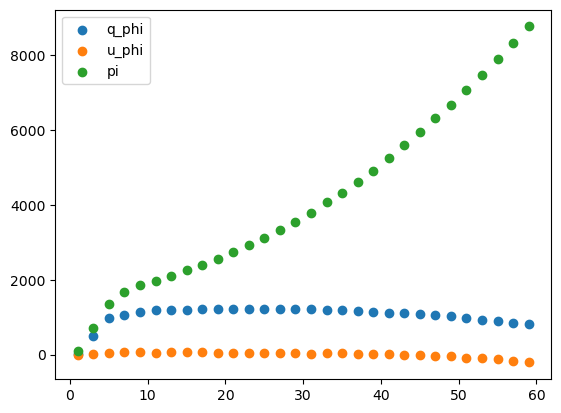

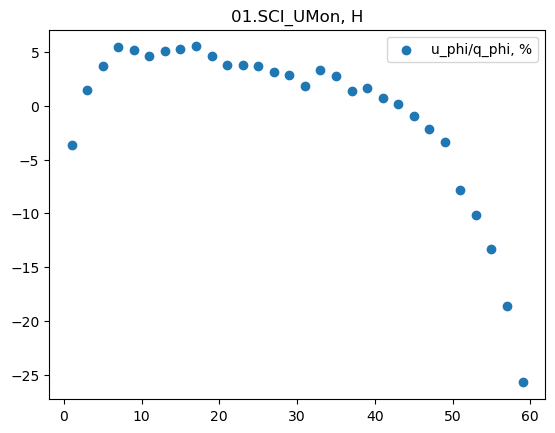

abs u_phi/q_phi for largest apperture 0.804663 , -/pi  0.37686488
abs q_phi/pi for largest apperture 0.4683512


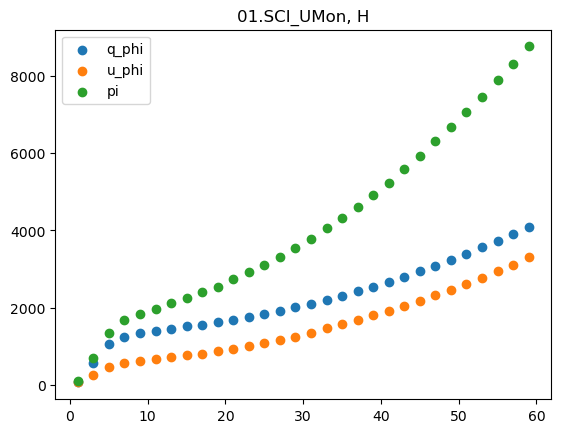

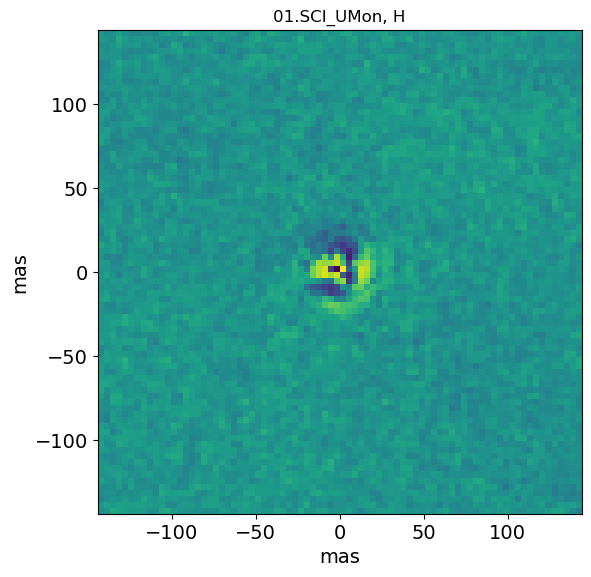

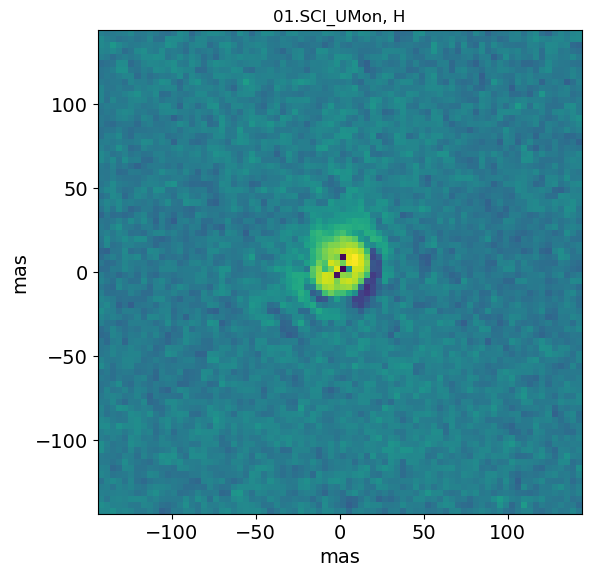

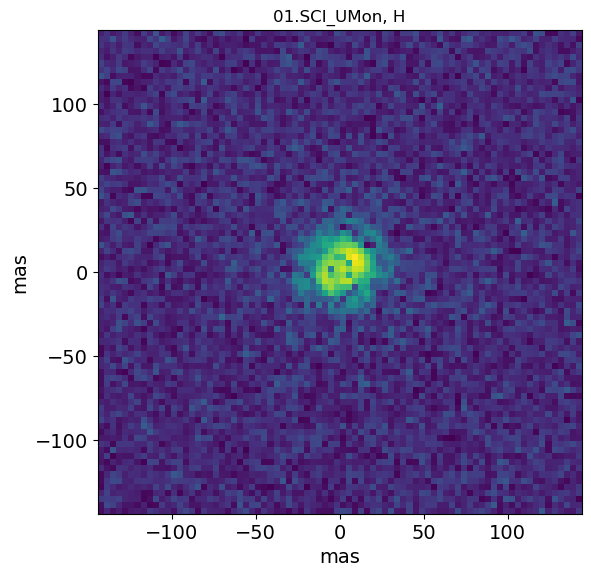

In [27]:
for star in stars:

    figfolder='/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/'+star+'/Quality_indiv_cycles/IRDISimg/'
    create_dir(figfolder)
    print(star)

    dirdat0='/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/'+star+'/IRDAP_reduced/reduced_pdi/star_pol_subtr/'
    files = os.listdir(dirdat0)
    ifile = '*U_phi_star_pol_subtr.fits'
    for file in files:
        if fnmatch.fnmatch(file, ifile):
            hdul = fits.open(dirdat0 + file)
            u_phi_nondec = hdul['Primary'].data
            n=u_phi_nondec.shape[0]

    ifile = '*Q_phi_star_pol_subtr.fits'
    for file in files:
        if fnmatch.fnmatch(file, ifile):
            hdul = fits.open(dirdat0 + file)
            q_phi_nondec = hdul['Primary'].data

    ifile = '*I_pol_star_pol_subtr.fits'
    for file in files:
        if fnmatch.fnmatch(file, ifile):
            hdul = fits.open(dirdat0 + file)
            pi_nondec = hdul['Primary'].data

    u_phi_an= u_phi_nondec*1.0

       #Creating grid for the multiplying the image by the separation from star.
    xr = np.linspace(-n/2., n/2., num=n)
    yr = np.linspace(-n/2., n/2., num=n)
    Xr, Yr = np.meshgrid(xr, yr)
    R_an = np.sqrt(Xr**2 + Yr**2)


    hist_var_ar=[]
    hist_mean_ar=[]
    for hi_r in range (3,200,1):
        mask = (R_an < hi_r) & (R_an >=(hi_r-(math.sqrt(hi_r))))
        image_u=u_phi_an[mask]
        hist_variance=math.sqrt(np.var(image_u)/len(image_u))
        hist_image_mean=np.mean(image_u)
        hist_var_ar.append(hist_variance)
        hist_mean_ar.append(hist_image_mean)


    mean_over_var=np.array(hist_mean_ar)/np.array(hist_var_ar)
    if fittype=='1':
        mean_over_var_V=mean_over_var
    # if fittype=='2':
    #     mean_over_var_I=mean_over_var

    n_bins = 50
    fig, axs = plt.subplots(1, 1, tight_layout=True,figsize=(16,12))
    somth1, bins,somth2 = plt.hist(mean_over_var, bins=n_bins, density=True, alpha=0.7, rwidth=0.85)
    #print(somth1, bins,somth2)
    mu, sigma = scipy.stats.norm.fit(mean_over_var)

    best_fit_line = scipy.stats.norm.pdf(bins, mu, sigma)
    plt.plot(bins, best_fit_line, label="\n".join(wrap('norm. dist., $\sigma$=%.3f, $\mu$=%.3f'%(sigma,mu),40)))
    mu, sigma =(0,1)
    best_fit_line = scipy.stats.norm.pdf(bins, mu, sigma)
    plt.plot(bins, best_fit_line, label="\n".join(wrap('st. norm. dist., $\sigma$=%.3f, $\mu$=%.3f'%(sigma,mu), 40)))
    plt.title(star+', '+band[int(fittype)-1], fontsize=32)
    plt.xlabel(r'Mean U$_\phi$ flux / $\sigma_A$', fontsize=28)
    plt.ylabel('Probability density', fontsize=28)
    axs.xaxis.set_tick_params(labelsize=20)
    axs.yaxis.set_tick_params(labelsize=20)
    plt.legend(fontsize=24, loc='upper right')
    plt.savefig(figfolder+ star +'_'+band[int(fittype)-1]+ "hist.jpeg")
    plt.show()
    plt.close()

    q_phi_sum=[]
    u_phi_sum=[]
    pi_sum=[]

    for i_r in range(1,60,2):
        q_phi_sum.append(np.sum(q_phi_nondec[R_an<=i_r]))
        u_phi_sum.append(np.sum(u_phi_nondec[R_an<=i_r]))
        pi_sum.append(np.sum(pi_nondec[R_an<=i_r]))

    q_phi_sum=np.array(q_phi_sum)
    u_phi_sum=np.array(u_phi_sum)
    pi_sum=np.array(pi_sum)
    print('max u_phi', np.max(u_phi_sum))

    print('u_phi/q_phi for largest apperture', u_phi_sum[-1]/q_phi_sum[-1], ', -/pi ', u_phi_sum[-1]/pi_sum[-1])
    print('q_phi/pi for largest apperture', q_phi_sum[-1]/pi_sum[-1])


    i_r_ar=range(1,60,2)
    plt.scatter(i_r_ar, q_phi_sum, label='q_phi')
    plt.scatter(i_r_ar, u_phi_sum, label='u_phi')
    plt.scatter(i_r_ar, pi_sum, label='pi')
    #plt.yscale('log')
    plt.legend()
    plt.show()
    plt.close()

    plt.scatter(i_r_ar, u_phi_sum/q_phi_sum*100, label='u_phi/q_phi, %')
    #plt.ylim(-10,10)
    plt.legend()
    plt.title(star+', '+band[int(fittype)-1])
    plt.show()
    plt.close()


    #now for absolute values
    q_phi_sum=[]
    u_phi_sum=[]
    pi_sum=[]

    for i_r in range(1,60,2):
        q_phi_sum.append(np.sum(abs(q_phi_nondec[R_an<=i_r])))
        u_phi_sum.append(np.sum(abs(u_phi_nondec[R_an<=i_r])))
        pi_sum.append(np.sum(abs(pi_nondec[R_an<=i_r])))

    q_phi_sum=np.array(q_phi_sum)
    u_phi_sum=np.array(u_phi_sum)
    pi_sum=np.array(pi_sum)

    print('abs u_phi/q_phi for largest apperture', u_phi_sum[-1]/q_phi_sum[-1], ', -/pi ', u_phi_sum[-1]/pi_sum[-1])
    print('abs q_phi/pi for largest apperture', q_phi_sum[-1]/pi_sum[-1])
    i_r_ar=range(1,60,2)
    plt.scatter(i_r_ar, q_phi_sum, label='q_phi')
    plt.scatter(i_r_ar, u_phi_sum, label='u_phi')
    plt.scatter(i_r_ar, pi_sum, label='pi')
    plt.title('abs')
    plt.legend()
    plt.title(star+', '+band[int(fittype)-1])
    plt.show()
    plt.close()


    d = (n-1) * ps / 2
    lim=40

    for image_a in [u_phi_nondec,q_phi_nondec,pi_nondec]:

        fig, ax = plt.subplots(figsize=(6, 6))
        image = np.arcsinh(image_a)
        max = np.max(image[int(n/2-lim/2):int(n/2+lim/2),int(n/2-lim/2):int(n/2+lim/2)])
        min=np.min(image[int(n/2-lim/2):int(n/2+lim/2),int(n/2-lim/2):int(n/2+lim/2)])
        ax.imshow(image, vmin=min, vmax=max, extent=(-d, d, d, -d))
        ax.set_xlim(-lim * ps, lim * ps)
        ax.set_ylim(-lim * ps, lim * ps)
        ax.set_xlabel('mas',fontsize=14)
        ax.set_ylabel('mas',fontsize=14)
        ax.tick_params(axis='both',labelsize=14)
        plt.title(star+', '+band[int(fittype)-1])
        plt.tight_layout()
        plt.show()
        plt.close()


    #
    # n_bins = 50
    # fig, axs = plt.subplots(1, 1, tight_layout=True,figsize=(16,12))
    # somth1_V, bins_V,somth2_V = plt.hist(mean_over_var_V, bins=n_bins, density=True, alpha=0.8, rwidth=0.85, color='gold')
    # mu_V, sigma_V = scipy.stats.norm.fit(mean_over_var_V)
    # best_fit_line_V = scipy.stats.norm.pdf(bins_V, mu_V, sigma_V)
    # plt.plot(bins_V, best_fit_line_V, label="\n".join(wrap('norm. dist., V-band, $\sigma$=%.3f, $\mu$=%.3f'%(sigma_V,mu_V),40)), color='orange', linewidth=3)
    #
    # somth1_I, bins_I,somth2_I = plt.hist(mean_over_var_I, bins=n_bins, density=True, alpha=0.4, rwidth=0.85, color='blue')
    # mu_I, sigma_I = scipy.stats.norm.fit(mean_over_var_I)
    # best_fit_line_I = scipy.stats.norm.pdf(bins_I, mu_I, sigma_I)
    # plt.plot(bins_I, best_fit_line_I, label="\n".join(wrap('norm. dist., V-band, $\sigma$=%.3f, $\mu$=%.3f'%(sigma_I,mu_I),40)), color='blue', linewidth=3)
    #
    # mu, sigma =(0,1)
    # best_fit_line = scipy.stats.norm.pdf(bins, mu, sigma)
    # plt.plot(bins, best_fit_line, label="\n".join(wrap('st. norm. dist., $\sigma$=%.3f, $\mu$=%.3f'%(sigma,mu), 40)), color='black', linewidth=2)
    #
    # plt.title(starnames[star], fontsize=32)
    # plt.xlabel(r'Mean U$_\phi$ flux / $\sigma_A$', fontsize=28)
    # plt.ylabel('Probability density', fontsize=28)
    # axs.xaxis.set_tick_params(labelsize=20)
    # axs.yaxis.set_tick_params(labelsize=20)
    # plt.legend(fontsize=24, loc='upper right')
    # plt.savefig(figfolder+ star +'_both_bands_hist.jpeg')
    # plt.show()
    # plt.close()

In [28]:
iband

['B_H']